<a href="https://colab.research.google.com/github/nitrogenlab/pyompa/blob/dev/examples/GP15analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gsw
import gsw

     |████████████████████████████████| 2.4MB 6.2MB/s 


In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2021-04-16 17:31:09--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 173.194.195.101, 173.194.195.139, 173.194.195.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.195.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k52pjp9qqm1o8d1ofg12t46s4ebmrsq5/1618594200000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2021-04-16 17:31:10--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k52pjp9qqm1o8d1ofg12t46s4ebmrsq5/1618594200000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 74.125.129.132, 2607:f8b0:4001:c15::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-

In [3]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

/content
Cloning into 'pyompa'...
remote: Enumerating objects: 754, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 754 (delta 36), reused 47 (delta 22), pack-reused 692
Receiving objects: 100% (754/754), 5.94 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (522/522), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit 5280f4b0ef1509202d4f1ca1294cd776372b37f8 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Fri Apr 16 10:30:39 2021 -0700

    clean up debug print statements
Processing /content/pyompa
  Created wheel for pyompa: filename=pyompa-0.4.0.0-cp37-none-any.whl size=23438 sha256=eae3762069920570c16177f6aa45cf9a32e7b5b556b0d8595837a1bc2e20be58
  Stored in directory: /tmp/pip-ephem-wheel-cache-iyrs_hcn/wheels/c8/e7/18/86bb9113ba57075c1244f892ac172edfebb6b9de263279873f
Successfully built pyompa
/content


<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [4]:
import pandas as pd
import numpy as np

def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "silicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "lat"
header[9] = "lon"

header[0] = "stnnbr"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)

#remove bad data
for flag_type in ["bottle flag", "bottle salinity flag", "bottle oxygen flag",
                  "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 2]
gp15_df = pd.DataFrame(gp15_df)

#create PO offset
#gp15_df["phosphate"] = gp15_df["phosphate"] - 0.2

#add PO and NO to data frame
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["lon"],
                                   lat=gp15_df["lat"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sigma0"] = sig0

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["lat"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["Depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["lat"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

Rows: 940
Rows without NA values: 926


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [5]:
def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name",
                               "potential_temp", "practical_salinity",
                               "oxygen", "phosphate", "silicate",
                               "nitrate", "spiciness", "PV"])
    augment_df_with_PO_NO_SiO(df)
    return df

                             #Temp  Sal     Oxy     Phos   Sili   Nitr    Spic      Vort
P16_Emilie_AAIW = ["AAIW",    5.68, 34.307, 237.0,  1.77,  16.60, 25.5,   0.068,    88.86E-12]
PSUW =            ["PSUW",    4.03, 33.38,	174.7,	2.35,  59.34, 31.24,  -0.964,  970.78E-12]
GLODAP_ESSW =     ["ESSW",   12.2,  34.86,  84.6,   1.87,  21.58, 25.87,   1.419,    2.66E-12]
GLODAP_mystery =  ["Mystery", 2.09, 34.53,   36.1,  3.03, 168.87, 43.5,  -0.154,    26.95E-12]
GLODAP_EqPIW =    ["EqPIW",   7.65, 34.60,   48.50, 2.71,  44.53, 38.26,  0.568,     0.01E-12]
GLODAP_NPIW =     ["NPIW",    4.72, 34,      81.8,  2.64,  79.87, 36.48, -0.262,   130.26E-12]
PDW1 =            ["PDW1",    1.78, 34.59,   59.60, 2.92, 166.62, 41.38, -0.140,    19.14E-12]
P16_UCDW =        ["UCDW",    2.6,  34.575, 168,    2.4,   85.7,  34.4,  -0.1,      37.49E-12]
PDW23 =           ["PDW23",   1.23, 34.67,  128.50, 2.62, 164.89, 37.24, -0.182,     6.05E-12]
P16_LCDW =        ["LCDW",    1.62, 34.738, 195,    2.17,  96.6,  31,    -0.066,    12.55E-12]
GLODAP_AABW =     ["AABW",    0.18, 34.70,  219,    2.27, 124.45, 32.57, -0.203,     2.90E-12]


In [6]:
import pyompa
reload(pyompa)
from pyompa import OMPAProblem, EndMemExpPenaltyFunc
from collections import OrderedDict

#gp15_intermediate = gp15_df[(gp15_df["sigma0"] >= 26.6)
#                            & (gp15_df["sigma0"] <= 27.72)]

gp15_intermediateanddeep = pd.DataFrame(gp15_df[(gp15_df["sigma0"] >= 26.6)])

#intermediate_paramsandweighting_nospicy = ([("potential_temp",140),
#                                            ("practical_salinity",100),
#                                            ("silicate",30),
#                                            ("NO",10),
#                                            #("PO",10),
#                                            #("spiciness",10),
#                                            #("PV",10),
#                                           ], [])

#default redfield: C:N:P:O = 106:16:1:-155
#Teng et al says C:P is in the range 66 to 209
#Assuming relative ratios of other things stay the same, then -O/P goes from
# -155*(66/106) to -155*(209/106), and N:P goes from
#

convertedparamgroups_staticremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen": -155, "phosphate": 1.0, "nitrate": 16.0}],
        always_positive=False)
]

convertedparamgroups_flexibleremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[#Representing C:P = 66
                           {"oxygen": -155*(66.0/106.0),
                            "phosphate": 1.0,
                            "nitrate": 16.0*(66.0/106.0)},
                           #Representing C:P = 209
                           {"oxygen": -155*(209.0/106.0),
                            "phosphate": 1.0,
                            "nitrate": 16.0*(209.0/106.0)}
                          ],
        always_positive=False)
]

"""convertedparamgroups_flexibleremineralization = [
    pyompa.ConvertedParamGroup(
        groupname="oxygen_deficit",
        conversion_ratios=[#Representing C:P = 66
                           {"oxygen": -1,
                            "phosphate": 1.0/(155.0*(66.0/106.0)),
                            "nitrate": 1.0/9.6875},
                           #Representing C:P = 209
                           {"oxygen": -1,
                            "phosphate": 1.0/(155.0*(209.0/106.0)),
                            "nitrate": 1.0/9.6875}
                          ],
        always_positive=False)
]"""

rian_weighting = {
    "potential_temp": 56.0,
    "practical_salinity": 80.0,
    "silicate": 3.0,
    "nitrate": 5.0,
    "phosphate": 5.0,
    "oxygen": 1.0,
    "NO": 1.0,
    "PO": 0.5
}

withconversion_paramnames = ["potential_temp", "practical_salinity",
                             "silicate", "nitrate", "phosphate", "oxygen"]
noconversion_paramnames = ["potential_temp", "practical_salinity",
                           "silicate", "NO", "PO"]  

flexiblereminratio_settings = {
    "param_names": withconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": convertedparamgroups_flexibleremineralization}

staticreminratio_settings = {
    "param_names": withconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": convertedparamgroups_staticremineralization}

noremin_settings = {
    "param_names": noconversion_paramnames,
    "param_weightings": rian_weighting,
    "convertedparam_groups": []}

#Analysis for intermediate and deep waters combined
endmember_usagepenalty = {
    PSUW[0]: EndMemExpPenaltyFunc(
        spec={'lat': {'type':'latlon_default', 'lowerbound':10}}),
    P16_LCDW[0]: EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.72}}),
    GLODAP_AABW[0]: EndMemExpPenaltyFunc(
        spec={'sigma0': {'type':'density_default', 'lowerbound':27.72}})
}
intermediateanddeep_endmember_df = prepare_endmember_df([P16_Emilie_AAIW,
                                                         PSUW,
                                                         GLODAP_ESSW,
                                                         GLODAP_NPIW,
                                                         PDW1,
                                                         P16_UCDW,
                                                         PDW23,
                                                         P16_LCDW,
                                                         GLODAP_AABW
                                                         ])

intermediateanddeep_settingtosoln = OrderedDict()

for setting_name, setting in [("flexiblereminratio", flexiblereminratio_settings),
                              ("staticreminratio", staticreminratio_settings),
                              ("noremin_settings", noremin_settings)
                              ]:
  print("On setting:", setting_name)
  ompa_soln = OMPAProblem(
              obs_df=gp15_intermediateanddeep,
              endmembername_to_usagepenaltyfunc=endmember_usagepenalty,
              **setting).solve(
                  intermediateanddeep_endmember_df,
                  endmember_name_column="endmember_name")
  intermediateanddeep_settingtosoln[setting_name] = ompa_soln


On setting: flexiblereminratio
Adding penalty for PSUW
Adding penalty for LCDW
Adding penalty for AABW
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'nitrate', 'phosphate', 'oxygen']
param weighting: [56. 80.  3.  5.  5.  1.]
Conversion ratios:
OrderedDict([('phosphate_remin', defaultdict(<class 'list'>, {'nitrate': [9.962264150943396, 31.547169811320753], 'oxygen': [-96.50943396226414, -305.6132075471698], 'phosphate': [1.0, 1.0]}))])
Trying convertedvariable sign constraint: [1 1]
status: optimal
optimal value 25198.072068757465
Original weighted sum squares: 25179.496560826952
Post fix weighted sum squared: 25179.707713026663
Trying convertedvariable sign constraint: [-1 -1]
status: optimal
optimal value 872370.3630515792
Original weighted sum squares: 872352.9075755096
Post fix weighted sum squared: 872352.9081076
status: optimal
optimal value 22449.815059365075
Original weighted sum squares: 22429.834660563396
Post fix weighted sum squared: 22429.97920135397


flexiblereminratio


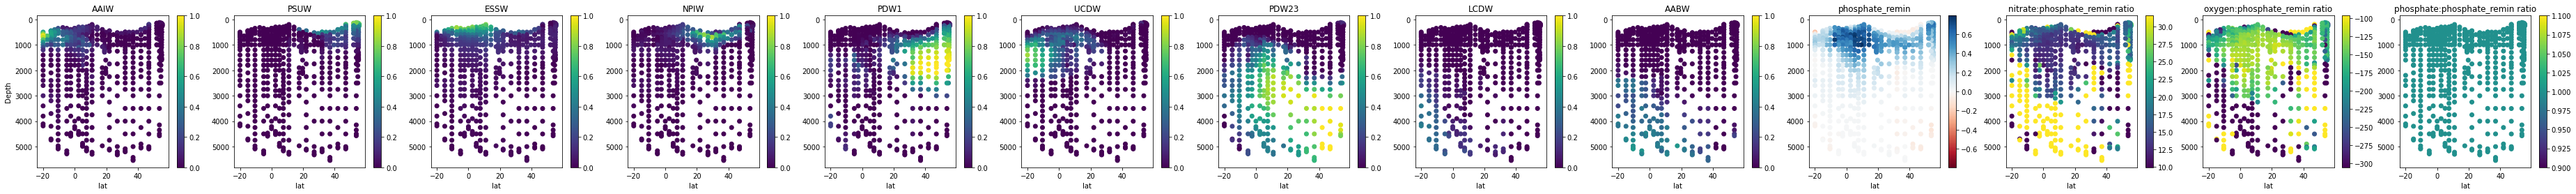

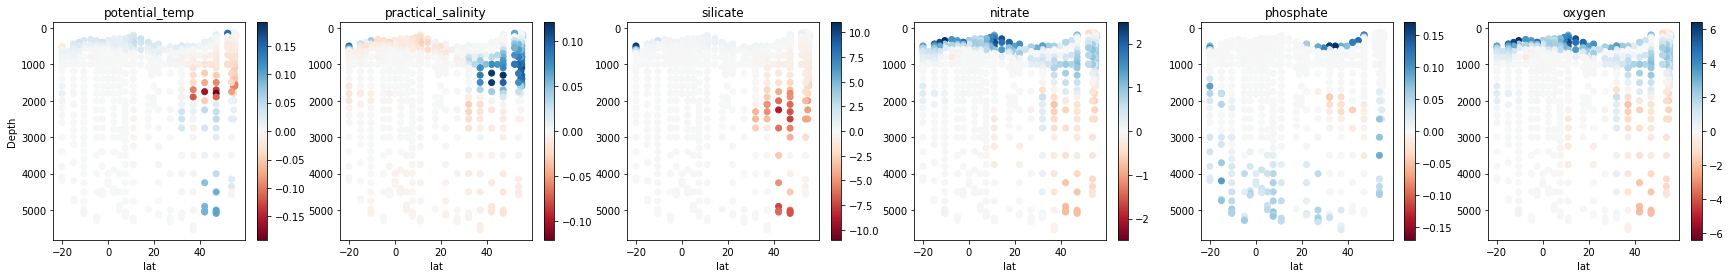

staticreminratio


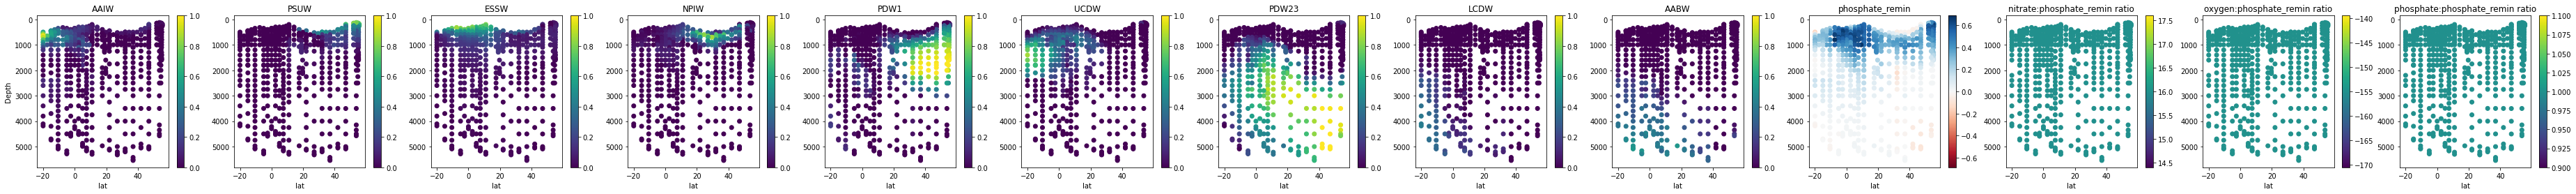

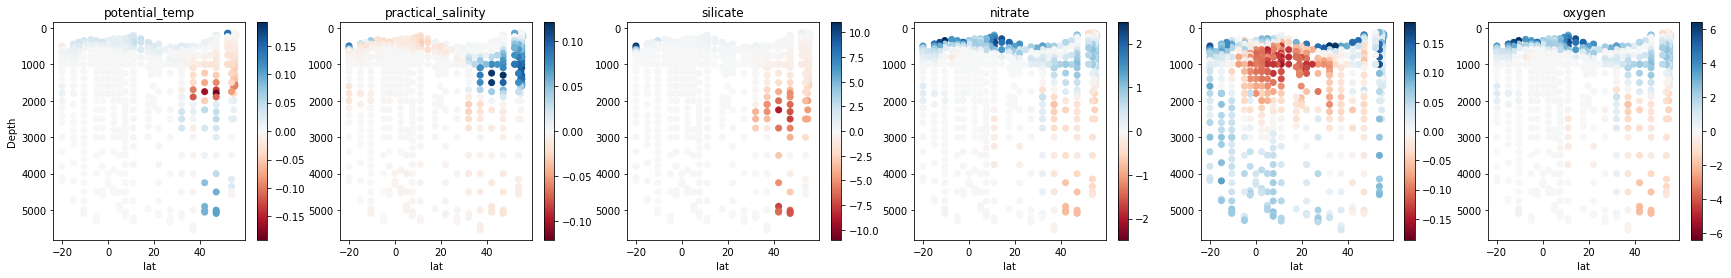

noremin_settings


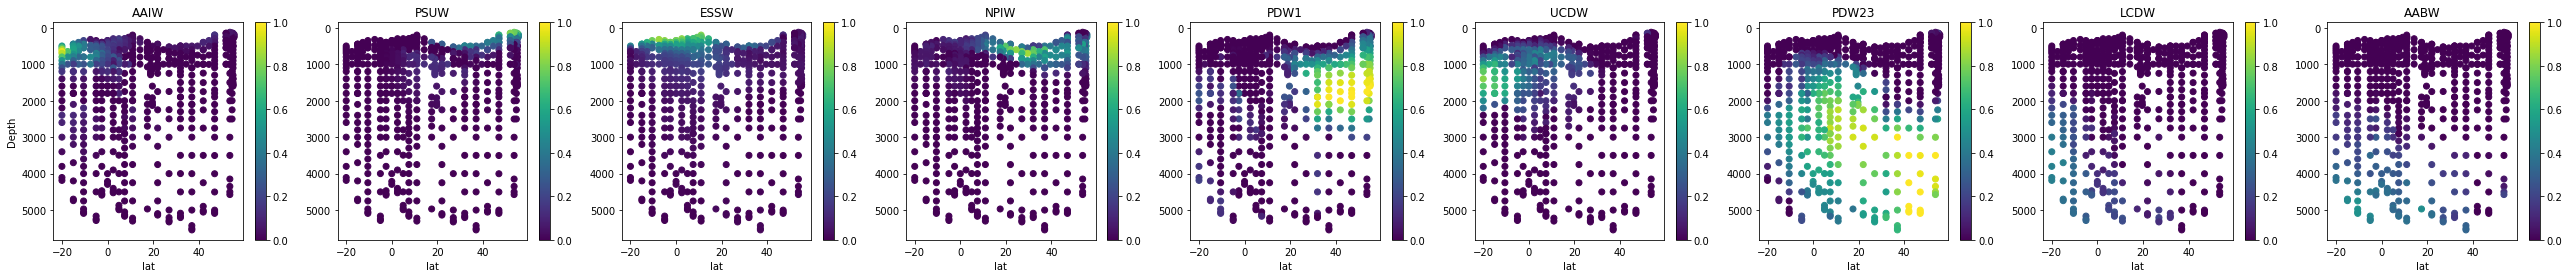

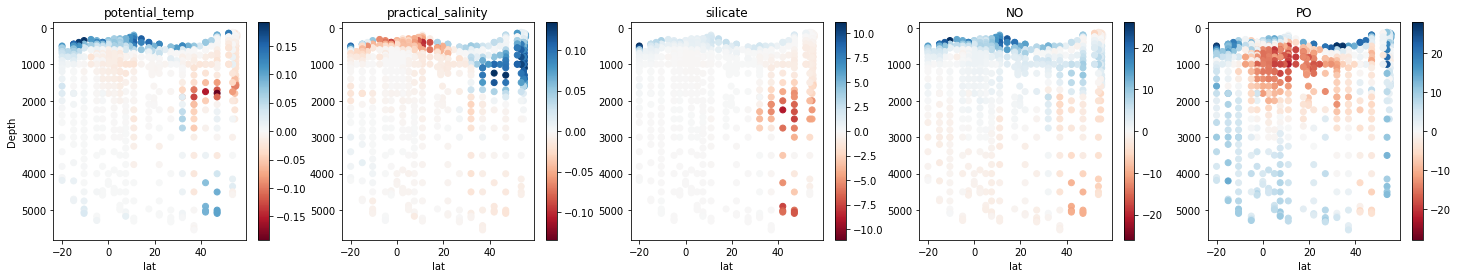

In [7]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "Depth"

for settingname in intermediateanddeep_settingtosoln:
    print(settingname)
    ompa_soln = intermediateanddeep_settingtosoln[settingname]
    plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                      xaxis_colname="lat",
                                      yaxis_colname=yaxis_colname)
    plot_ompasoln_residuals(ompa_soln=ompa_soln,
                            xaxis_colname="lat",
                            yaxis_colname=yaxis_colname)